# Implementation of the Spectral Tensor-Train Decomposition

## Overview and Setup

First, some setup. The **TensorToolbox** library is required.

In [84]:
# Place all imports here

import numpy as np
import numpy.linalg as la
import tensorly as tl
import matplotlib.pyplot as plt
import itertools

# The authors gave their own implementation of the tensor-train decomposition - I will download and test it
# To install dependencies, run pip install TensorToolbox, pip install SpectralToolbox, pip install UQToolbox

from scipy import stats
import TensorToolbox as TT
from TensorToolbox.core import STT
import SpectralToolbox

In [4]:
def lsqError(set1, set2):
    '''
    Takes two equal-sized numpy arrays of real numbers, 
    returns the least-squares error between them
    '''
    return la.norm(set1 - set2)

In [52]:
evaluation_counter = 0

# Define a 4D polynomial function for testing purposes
def poly1(X, params=0):
    global evaluation_counter
    
    # Increment the evaluation counter with the value of the input parameter
    evaluation_counter += params
    
    return X[0]**7 + X[1]**6 + X[2]**5 + X[3]**4

# Quadratic polynomial
def poly2(X, params=_):
    return X[0]**2 + X[1]**2

print(poly1([5, 2, 3, 4], 0))
print(poly2([5, 2, 3, 4], 0))
print(evaluation_counter)


def getEquispaceGrid(n_dim, rng, subdivisions):
    '''
    Returns a grid of equally-spaced points in the specified number of dimensions
    
    n_dim       : The number of dimensions to construct the tensor grid in
    rng         : The maximum dimension coordinate (grid starts at 0)
    subdivisions: Number of subdivisions of the grid to construct
    '''
    return np.array([np.array(range(subdivisions + 1)) * rng * 1.0 / subdivisions for i in range(n_dim)])
    

def getDummyGrid():
    # Return an ultra-basic dummy grid for poly1
    grid = np.array([[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]])
    return grid

print(getEquispaceGrid(5, 5.0, 9))

def evaluateGrid(grid, fcn):
    '''
    Loops over a grid in specified order and computes the specified function at each
    point in the grid, returning a list of computed values.
    '''
    values = np.zeros(len(grid[0]) ** len(grid))
    idx = 0
    for permutation in itertools.product(range(len(grid[0])), repeat=len(grid)):
        pt = np.array([grid[i][permutation[i]] for i in range(len(permutation))])
        values[idx] = fcn(pt)
        idx += 1
        
    return values

78688
29
0
[[0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
  3.33333333 3.88888889 4.44444444 5.        ]
 [0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
  3.33333333 3.88888889 4.44444444 5.        ]
 [0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
  3.33333333 3.88888889 4.44444444 5.        ]
 [0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
  3.33333333 3.88888889 4.44444444 5.        ]
 [0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
  3.33333333 3.88888889 4.44444444 5.        ]]


# Testing the Procedures Presented in the Paper

In [87]:
# Construct a test approximation
approximation = STT(poly1, getDummyGrid(), params=0, surrogateONOFF = True, surrogate_type='LinearInterpolation')

# Call the approximation
x = approximation.build()

approximation.__call__(np.array([0, 1, 2, 2.6]))

88.00000000000027

- At this point, we've successfully constructed an approximation. Now, we can test the function on different grid sizes, etc.

In [91]:
# Investigate the effect of number of grid subdivisions on the mean-squared error (grid has fixed range, polynomial
# dimension held fixed)

# This tests only linear interpolation

# Test on the 4D polynomial

rng = 10
subdivs = np.array(range(2, 100, 1))
errors = []
numEvaluations = []

# In this case, the test set will be a highly-subdivided tensor grid. Might implement a random version in the future.
test_grid = getEquispaceGrid(4, rng, 8)
ground_truth = evaluateGrid(test_grid, poly1)

for subdiv in subdivs:
    grid = getEquispaceGrid(4, rng, subdiv)
    print(grid)
    
    # Reset evaluation counter
    evaluation_counter = 0
    approximation = STT(poly1, grid, params=1, surrogateONOFF = True, surrogate_type='LinearInterpolation')
    #approximation.build()
    
    #numEvaluations.append(evaluation_counter)
    #approx = evaluateGrid(test_grid, approximation.__call__)
    #errors.append(lsqError(ground_truth, approx))
    
print('Done!')

[[ 0.  5. 10.]
 [ 0.  5. 10.]
 [ 0.  5. 10.]
 [ 0.  5. 10.]]
[[ 0.          3.33333333  6.66666667 10.        ]
 [ 0.          3.33333333  6.66666667 10.        ]
 [ 0.          3.33333333  6.66666667 10.        ]
 [ 0.          3.33333333  6.66666667 10.        ]]
[[ 0.   2.5  5.   7.5 10. ]
 [ 0.   2.5  5.   7.5 10. ]
 [ 0.   2.5  5.   7.5 10. ]
 [ 0.   2.5  5.   7.5 10. ]]
[[ 0.  2.  4.  6.  8. 10.]
 [ 0.  2.  4.  6.  8. 10.]
 [ 0.  2.  4.  6.  8. 10.]
 [ 0.  2.  4.  6.  8. 10.]]
[[ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
  10.        ]
 [ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
  10.        ]
 [ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
  10.        ]
 [ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
  10.        ]]
[[ 0.          1.42857143  2.85714286  4.28571429  5.71428571  7.14285714
   8.57142857 10.        ]
 [ 0.          1.42857143  2.85714286  4.28571429  5.7

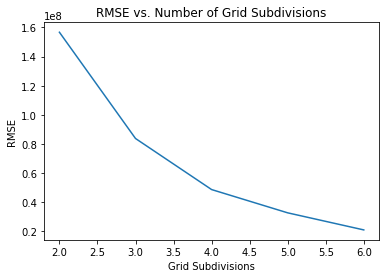

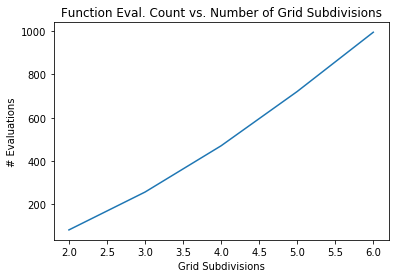

In [74]:
# Plot the results
plt.figure()
plt.plot(subdivs, errors)
plt.xlabel('Grid Subdivisions')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Grid Subdivisions, Linear')
plt.show()

# Plot the results
plt.figure()
plt.plot(subdivs, numEvaluations)
plt.xlabel('Grid Subdivisions')
plt.ylabel('# Evaluations')
plt.title('Function Eval. Count vs. Number of Grid Subdivisions, Linear')
plt.show()

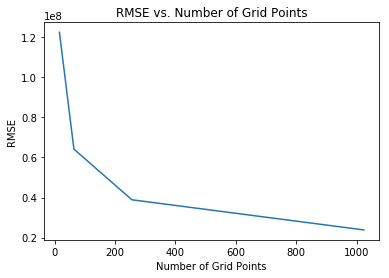

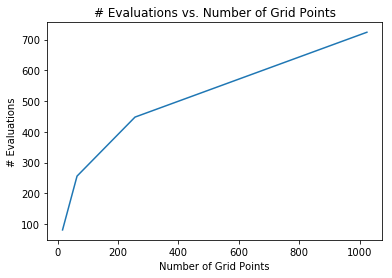

In [71]:
# Same results, but this time with the total number of tensor points instead of # of subdivisons

# Plot the results
plt.figure()
plt.plot([4 ** subdiv for subdiv in subdivs], errors)
plt.xlabel('Number of Grid Points')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Grid Points, Linear')
plt.show()

# Plot the results
plt.figure()
plt.plot([4 ** subdiv for subdiv in subdivs], numEvaluations)
plt.xlabel('Number of Grid Points')
plt.ylabel('# Evaluations')
plt.title('# Evaluations vs. Number of Grid Points, Linear')
plt.show()

[[ 0.  5. 10.]
 [ 0.  5. 10.]
 [ 0.  5. 10.]
 [ 0.  5. 10.]]
[[ 0.          3.33333333  6.66666667 10.        ]
 [ 0.          3.33333333  6.66666667 10.        ]
 [ 0.          3.33333333  6.66666667 10.        ]
 [ 0.          3.33333333  6.66666667 10.        ]]
[[ 0.   2.5  5.   7.5 10. ]
 [ 0.   2.5  5.   7.5 10. ]
 [ 0.   2.5  5.   7.5 10. ]
 [ 0.   2.5  5.   7.5 10. ]]
[[ 0.  2.  4.  6.  8. 10.]
 [ 0.  2.  4.  6.  8. 10.]
 [ 0.  2.  4.  6.  8. 10.]
 [ 0.  2.  4.  6.  8. 10.]]
[[ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
  10.        ]
 [ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
  10.        ]
 [ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
  10.        ]
 [ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
  10.        ]]
Done!


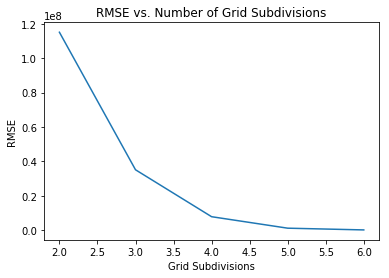

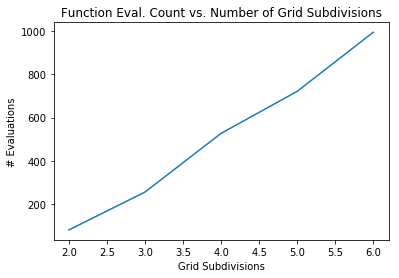

In [80]:
# Same tests on the weird degree 7 polynomial, except testing Lagrange interpolation this time

rng = 10
subdivs = np.array(range(2, 7, 1))
errors = []
numEvaluations = []


test_grid = getEquispaceGrid(4, rng, 8)
ground_truth = evaluateGrid(test_grid, poly1)

for subdiv in subdivs:
    grid = getEquispaceGrid(4, rng, subdiv)
    print(grid)
    
    # Reset evaluation counter
    evaluation_counter = 0
    approximation = STT(poly1, grid, params=1, surrogateONOFF = True, surrogate_type='LagrangeInterpolation')
    approximation.build()
    
    numEvaluations.append(evaluation_counter)
    approx = evaluateGrid(test_grid, approximation.__call__)
    errors.append(lsqError(ground_truth, approx))
    
print('Done!')

# Plot the results
plt.figure()
plt.plot(subdivs, errors)
plt.xlabel('Grid Subdivisions')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Grid Subdivisions, Lagrange')
plt.show()

# Plot the results
plt.figure()
plt.plot(subdivs, numEvaluations)
plt.xlabel('Grid Subdivisions')
plt.ylabel('# Evaluations')
plt.title('Function Eval. Count vs. Number of Grid Subdivisions, Lagrange')
plt.show()

- It's clear that Lagrange polynomial interpolation yields superior results to linear interpolation

In [86]:
# Same test with projection - this one yields a weird error

rng = 10
subdivs = np.array(range(2, 7, 1))
errors = []
numEvaluations = []


test_grid = getEquispaceGrid(4, rng, 8)
ground_truth = evaluateGrid(test_grid, poly1)

for subdiv in subdivs:
    grid = getEquispaceGrid(4, rng, subdiv)
    print(grid)
    
    # Reset evaluation counter
    evaluation_counter = 0
    approximation = STT(poly1, grid, params=1, surrogateONOFF = True, surrogate_type='Projection')
    approximation.build()
    
    numEvaluations.append(evaluation_counter)
    approx = evaluateGrid(test_grid, approximation.__call__)
    errors.append(lsqError(ground_truth, approx))
    


[[ 0.  5. 10.]
 [ 0.  5. 10.]
 [ 0.  5. 10.]
 [ 0.  5. 10.]]


AttributeError: 'NoneType' object has no attribute 'GradVandermonde'

# Homebrewed implementation

- In progess. Still need to find a set of orthonormal basis functions - Lagrange polynomials?

## Testing out TT-DMRG Cross
